In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import RoutingClient
from obspy import Stream
from obspy.geodetics import gps2dist_azimuth
from obspy import signal
from obspy import read
import matplotlib.pyplot as plt
import folium
import numpy as np
import json
import pandas as pd
from obspy.clients.fdsn.header import FDSNNoDataException
from scipy.signal import savgol_filter
import os
import folium
import numpy as np
import branca.colormap as cm

from obspy import Stream
from matplotlib.colors import LogNorm

import pandas as pd

Dtmin_Noise=-25
Dtmax_Noise=-5
Dtmin_Pn=-5.
Dtmax_Pn=10.
Dtmin_Sn=-5.
Dtmax_Sn=10.

vLg_max=3.5
vLg_min=3.1
vLg=0.5*(vLg_max+vLg_min)
vPg_max=6.2
vPg_min=5.2
vPg=0.5*(vPg_max+vPg_min)
print(vPg)
#vPg=6.

tminCoda=300.
tmaxCoda=320.

5.7


In [2]:
from new_functions import get_data2, big_downloader2, calc_amps, plot_stations_amps, plot_record_section, SNR_all, select_ratio, select_ratio_dict, update_event_file

To do: 
- plot the enevelopes

<class 'numpy.ndarray'>


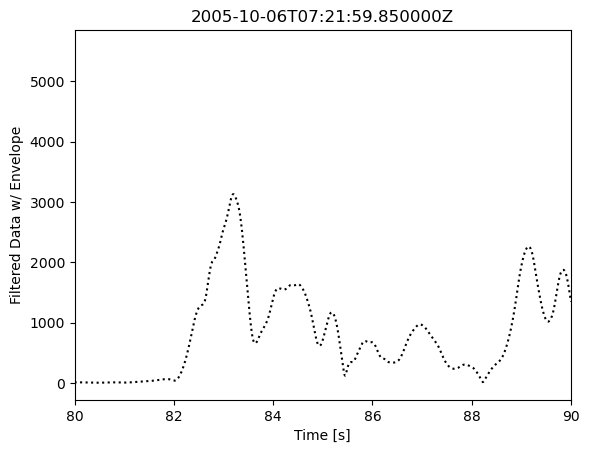

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
import obspy.signal


st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")
data = st[0].data
npts = st[0].stats.npts
samprate = st[0].stats.sampling_rate

# Filtering the Stream object
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)

# Envelope of filtered data
data_envelope = obspy.signal.filter.envelope(st_filt[0].data)
print(type(data_envelope))

# The plotting, plain matplotlib
t = np.arange(0, npts / samprate, 1 / samprate)
#plt.plot(t, st_filt[0].data, 'k')
plt.plot(t, data_envelope, 'k:')
plt.title(st[0].stats.starttime)
plt.ylabel('Filtered Data w/ Envelope')
plt.xlabel('Time [s]')
plt.xlim(80, 90)
plt.show()

#### Choose large earthquakes


In [4]:

catalogue_5 = pd.read_csv('eq_4_france.csv')
catalogue_5 = catalogue_5[catalogue_5['mag'] >= 4.0].reset_index(drop=True)
print(len(catalogue_5))
carte = folium.Map([45, 7], zoom_start=5)

for _, row in catalogue_5.iterrows():
    infos = f"{row['time']} ({row['latitude']}, {row['longitude']}) {row['mag']} m"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        tooltip=infos,
        fill=True,
        fill_opacity=1.0,
        radius=4,
    ).add_to(carte)

carte


95


In [5]:
#import warnings
#warnings.filterwarnings("ignore")
datacenters =['RESIF','ODC','ETH','INGV','GEOFON', 'IRIS', 'ICGC']#,'BGR']
directory='C:/UGA/Stage/Data/'
distmin=1.9
distmax=10.
start = UTCDateTime(catalogue_5['time'][22])
end = start + 700
eq_lon = float(catalogue_5['longitude'][22])
eq_lat = float(catalogue_5['latitude'][22])
st_all, stations_all, plot = big_downloader2(datacenters, start, end, eq_lon, eq_lat, distmin, distmax, directory, plot=False)
time_string = UTCDateTime.strftime(start, format="%Y_%m_%dT%H_%M_%S")


Earthquake at 2022-05-09T11:13:38.180000Z with magnitude 4.2


Processing stations of RESIF:   0%|          | 0/207 [00:00<?, ?it/s]

Processing stations of ODC:   0%|          | 0/185 [00:00<?, ?it/s]

Processing stations of ETH:   0%|          | 0/76 [00:00<?, ?it/s]

Processing stations of INGV:   0%|          | 0/249 [00:00<?, ?it/s]

Processing stations of GEOFON:   0%|          | 0/102 [00:00<?, ?it/s]

Processing stations of IRIS:   0%|          | 0/142 [00:00<?, ?it/s]

Processing stations of ICGC:   0%|          | 0/25 [00:00<?, ?it/s]

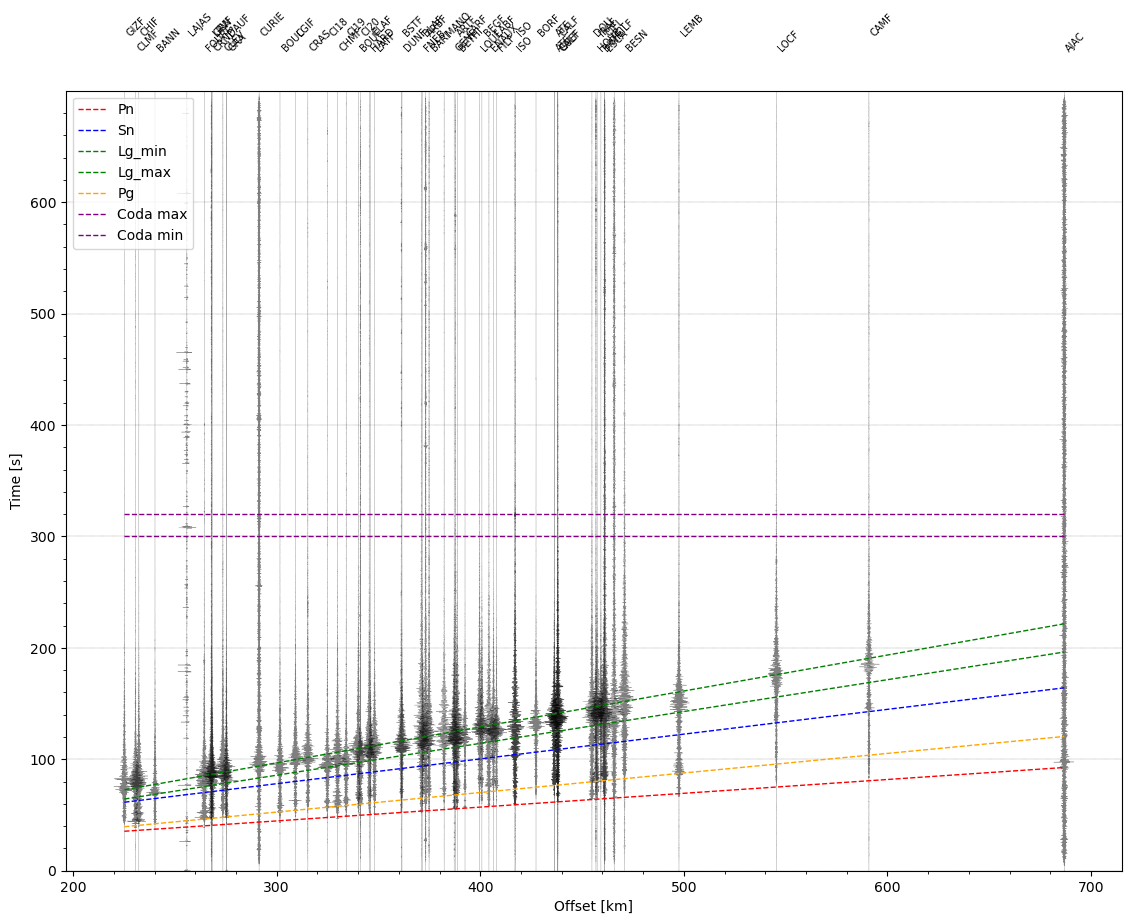

In [6]:
st_plot_filt_all=st_all.copy()
fmin=1
fmax=5
st_plot_filt_all.filter("bandpass", freqmin=fmin, freqmax=fmax)


plot, st_Lg0 = plot_record_section(st_plot_filt_all[0:60], stations_all[0:60], eq_lat, 
eq_lon, start, tracehodo=True, v_Lg_min=vLg_min, v_Lg_max=vLg_max, 
v_Pg=vPg)

In [7]:
print(len(st_plot_filt_all))

784


Choose now one station for a large event, plot the envelope and find the linear regime in the decay.
Then several stations can be plotted, the ratio and the coda amplitude ratio.


In [8]:
import obspy
from scipy.fftpack import hilbert
import numpy as np
#from obspy.signal.filter import envelope
from scipy.signal import resample


def envelope(data):
    hilb = hilbert(data)
    data = (data ** 2 + hilb ** 2) ** 0.5
    return data

st_envelope = obspy.Stream()
smallest = 7000
for tr in st_plot_filt_all:
    data_envelope = envelope(tr.data)
    npts = tr.stats.npts
    if npts >= smallest:
        samprate = tr.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)
        tr_envelope = obspy.Trace(data=data_envelope, header=tr.stats)
        #data_resampled = resample(tr_envelope.data, 10000)
        #tr_resampled = obspy.Trace(data=data_resampled, header=tr.stats)
        st_envelope.append(tr_envelope)
#st_envelope.write(f'/home/schreinl/Stage/Data/Envelopes/{time_string}_envelopes.mseed')





In [9]:
print(st_envelope[16].stats.station) #CI19 good for La Rochelle event

BORF


151
577


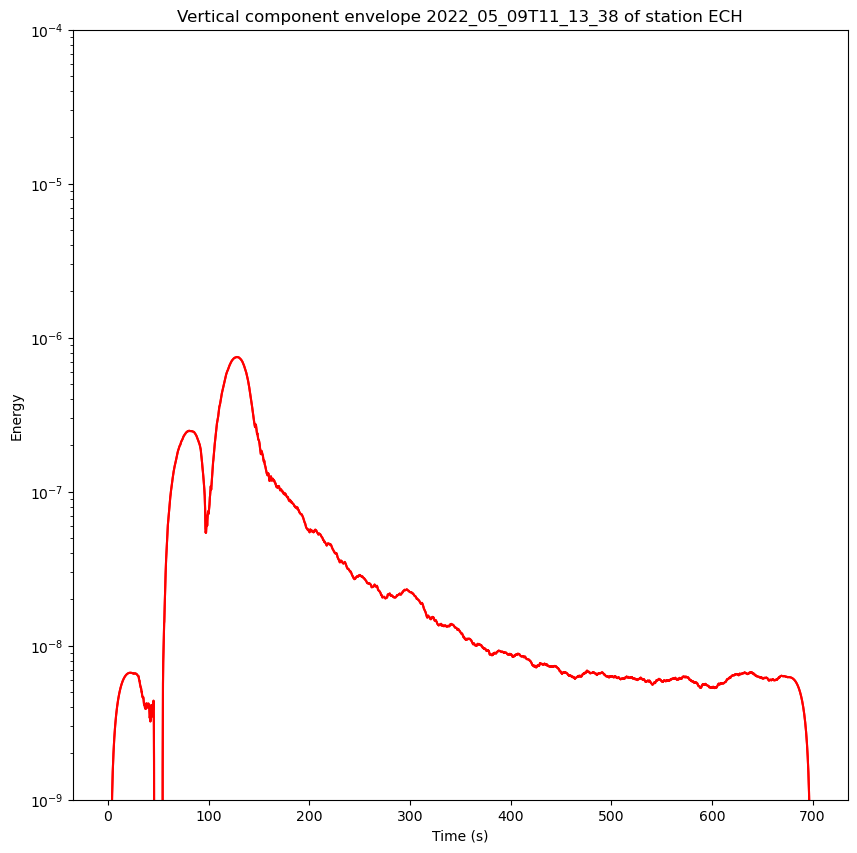

In [10]:
station = "ECH"
plt.figure(figsize=(10,10))
for i,tr in enumerate(st_envelope):
    if tr.stats.station == station:
        idx_reference = i
        print(i)
        npts = len(tr.data)
        samprate = tr.stats.sampling_rate #10000/700 
        t = np.arange(0, npts / samprate, 1 / samprate)

        #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
        
        window_length = 50*samprate #min(2000, npts)
        if window_length % 2 == 0:
            window_length -= 1
        yhat = savgol_filter(tr.data, int(window_length), 3) 
        t = t[:len(yhat)]
        plt.title(f"Vertical component envelope {time_string} of station {station}")
        plt.ylabel("Energy")
        plt.xlabel("Time (s)")
        #plt.semilogy(t,st_envelope[i])
        plt.semilogy(t,yhat, color='red')
        plt.ylim([1e-9,1e-4])
        #plt.xlim([100,350])
plt.show()


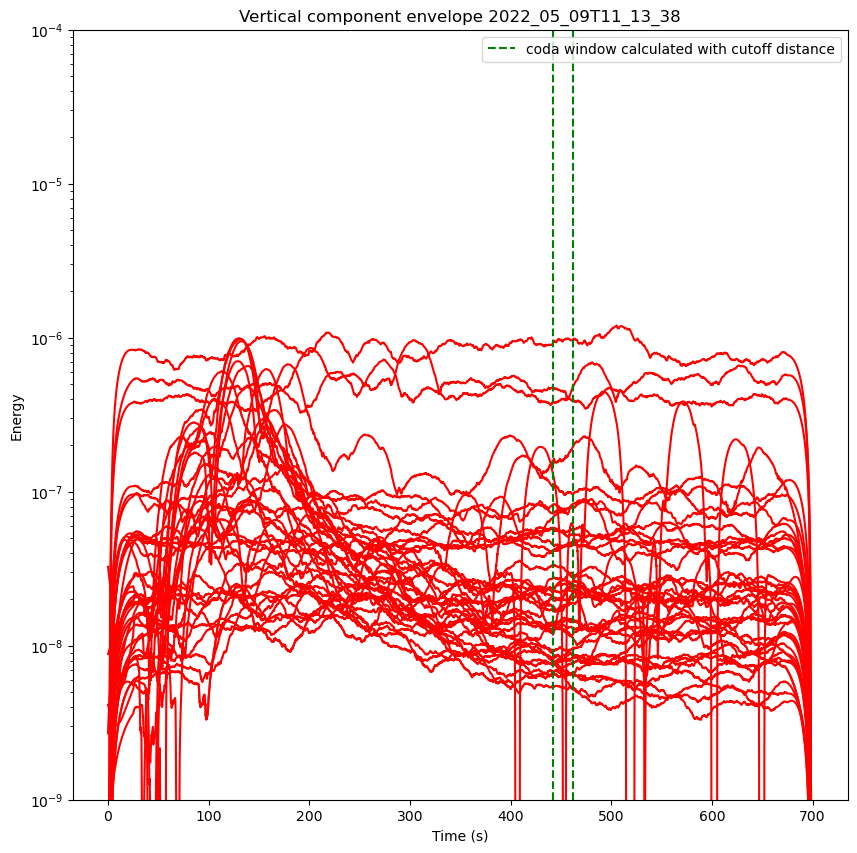

In [11]:
from scipy.signal import savgol_filter
from random import randint
def smooth_plot_envelope(time_string, n_traces,st_envelope,tmincoda_dist=442, tmaxcoda_dist=462):
    testing = [(randint(1, len(st_plot_filt_all))) for i in range(n_traces)]

    plt.figure(figsize=(10,10))
    for i in testing:
        if i < len(st_envelope):
            npts = len(st_envelope[i].data)
            samprate = st_envelope[i].stats.sampling_rate #10000/700 
            t = np.arange(0, npts / samprate, 1 / samprate)

            #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
            
            window_length = min(50*samprate, npts) # Ensure window_length is not greater than npts
            if window_length % 2 == 0:
                window_length -= 1
            yhat = savgol_filter(st_envelope[i].data, int(window_length), 3) 
            t = t[:len(yhat)]

            #plt.semilogy(t,st_envelope[i])
            plt.semilogy(t,yhat, color='red')
            plt.ylim([1e-9,1e-4])
            plt.title(f"Vertical component envelope {time_string}")
            plt.ylabel("Energy")
            plt.xlabel("Time (s)")
            #plt.xlim([100,350])
    plt.vlines(tmaxcoda_dist,ymax=1e-4,ymin=1e-9, label='coda window calculated with cutoff distance',colors='g',linestyles='--')
    plt.vlines(tmincoda_dist,ymax=1e-4,ymin=1e-9,colors='g',linestyles='--')
    #plt.vlines(350,ymax=1e-4,ymin=1e-9, label='coda window similar to Galina&Shapiro 2024',colors='b',linestyles='--')
    #plt.vlines(470,ymax=1e-4,ymin=1e-9,colors='b',linestyles='--')
    plt.legend()
    plt.show()

    return  
tset = smooth_plot_envelope(time_string, 50,st_envelope)

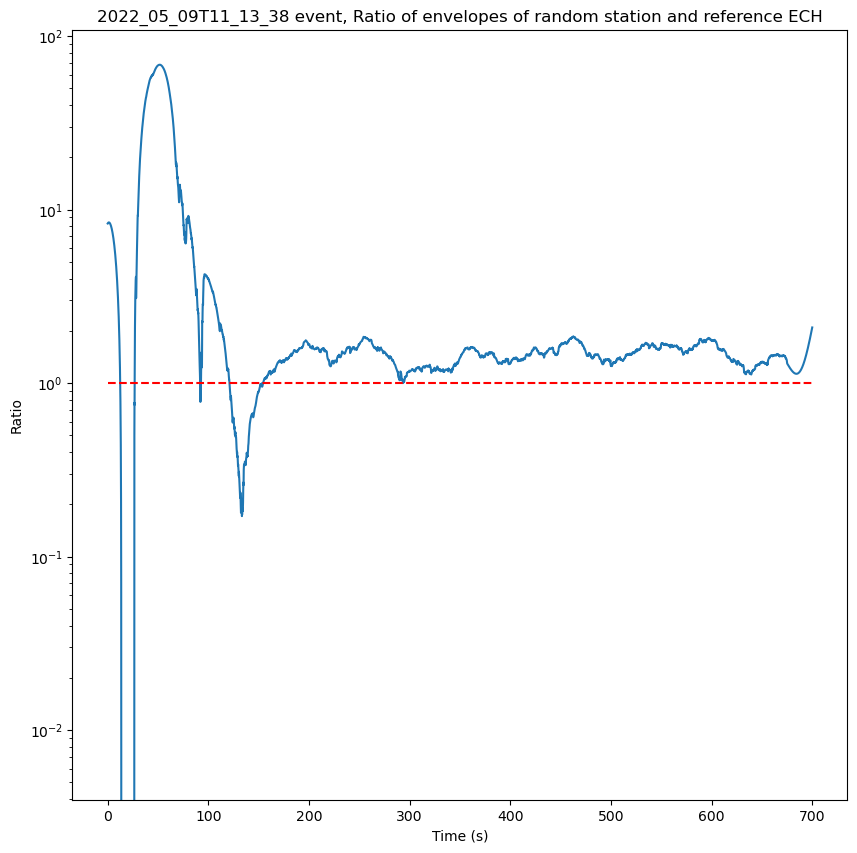

In [12]:
plt.figure(figsize=(10,10))
plt.semilogy(np.arange(0,700,0.01),savgol_filter(np.divide(resample(st_envelope[9].data,70000),resample(st_envelope[idx_reference].data,70000)),5000,3))
plt.title(f"{time_string} event, Ratio of envelopes of random station and reference ECH")
plt.xlabel('Time (s)')
plt.ylabel('Ratio')
plt.hlines(1,xmin=0,xmax=700, linestyles="--",colors='r')

#### Routine
Now implement a routine, which, for a given event, gets the data, filters it, calculates the envelope for each trace and writes it in a stream. Then a second stream is initialised, where all the envelopes are smoothed. These streams can be written to disk. Plot the coda amplitude ratio (from disk) of all stations in relation to the same station, and the envelope ratio with the same ratio against each other. Then plot the coda amp ratio of a specific ratio over magnitudes. 

For the amplitude ratios, choose a time window of length 120s, then calculate the amplitude ratio and its mean.

In [13]:
from scipy.signal import savgol_filter
import numpy as np
import obspy

def envelopes_routine1(event, st_envelope, ref_idx, codastart=350, codaend=470, coda_dist_start=300, coda_dist_end=350, plotting=False, n_traces=50):
    '''
    Takes as input a stream with the envelopes. It subsequently calculates the smoothed envelopes with a moving averaging
    window of 50s. These smooth envelopes are put in a new stream.
    '''
    st_envelope_smooth = obspy.Stream()
    
    for trace in st_envelope:
        npts = len(trace.data)
        samprate = trace.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)

        window_length = min(50 * samprate, npts) 
        if window_length % 2 == 0:
            window_length -= 1
        
        yhat = savgol_filter(trace.data, int(window_length), 3) 
        t = t[:len(yhat)]

        tr_envelope_smooth = obspy.Trace(data=yhat, header=trace.stats)
        st_envelope_smooth.append(tr_envelope_smooth)

    if plotting:
        smooth_plot_envelope(event, n_traces, st_envelope_smooth)

    station_data = {}

    for trace in st_envelope_smooth:
        dt = trace.stats.delta
        startcoda = int(codastart / dt) 
        endcoda = int(codaend / dt) 
        startcoda_dist = int(coda_dist_start / dt)
        endcoda_dist = int(coda_dist_end / dt)

        if startcoda >= len(trace.data) or endcoda > len(trace.data) or startcoda >= endcoda:
            continue

        coda = trace.data[startcoda:endcoda]
        coda_dist = trace.data[startcoda_dist:endcoda_dist]

        if len(coda) < 2 or len(coda_dist) < 2:
            continue  

        x_coda = np.linspace(0, (len(coda) - 1) * dt, len(coda))
        x_coda_dist = np.linspace(0, (len(coda_dist) - 1) * dt, len(coda_dist))

        coef_coda = np.polyfit(x_coda, coda, 1) if not np.all(coda == coda[0]) else [0, 0]
        coef_coda_dist = np.polyfit(x_coda_dist, coda_dist, 1) if not np.all(coda_dist == coda_dist[0]) else [0, 0]

        station_name = trace.stats.station 
        amplitude = (np.sqrt(np.dot(coda, coda.T)) / len(coda))
        
        station_data[station_name] = {
            "amplitude": amplitude,
            "coda_slope": coef_coda[0],
            "coda_dist_slope": coef_coda_dist[0]
        }

    return station_data, st_envelope_smooth

envelopes_amps, st_smooth = envelopes_routine1(time_string, st_envelope, ref_idx=idx_reference, plotting=False)
print(envelopes_amps)


{'GRA': {'amplitude': 2.0144781845853664e-10, 'coda_slope': 1.1574484849390186e-11, 'coda_dist_slope': 3.612610208759727e-11}, 'CI18': {'amplitude': 9.804684630924879e-11, 'coda_slope': 1.3632021863009367e-11, 'coda_dist_slope': -1.150553929019686e-10}, 'CI19': {'amplitude': 1.2314567374406335e-10, 'coda_slope': -3.3943497163019124e-11, 'coda_dist_slope': -3.9594642276533374e-11}, 'CI20': {'amplitude': 5.60829648010247e-10, 'coda_slope': 4.9505107118242527e-11, 'coda_dist_slope': -5.621428199517077e-10}, 'AJAC': {'amplitude': 2.1884481092019812e-10, 'coda_slope': 2.7828165008742446e-11, 'coda_dist_slope': -5.772043310683366e-11}, 'ARBF': {'amplitude': 4.923134348338346e-10, 'coda_slope': -3.569162393369063e-11, 'coda_dist_slope': 1.996677855205835e-11}, 'ARTF': {'amplitude': 2.799450353555424e-10, 'coda_slope': -3.126289486302887e-11, 'coda_dist_slope': -1.1365348671738845e-10}, 'ATE': {'amplitude': 9.282362010616451e-11, 'coda_slope': -3.05801996333074e-11, 'coda_dist_slope': -1.61558

In [14]:

from scipy.signal import savgol_filter

def envelopes_routine(event, st_envelope, ref_idx, codastart=350, codaend=470, coda_dist_start=300, coda_dist_end=350, plotting=False, n_traces=50):
    '''
    Takes as input a stream with the envelopes. It subsequently calculates the smoothed envelopes with a moving averaging
    window of 50s. These smooth envelopes are put in a new stream.
    
    '''
    st_envelope_smooth = obspy.Stream()
    
    for trace in st_envelope:
        npts = len(trace.data)
        samprate = trace.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)

        window_length = min(50 * samprate, npts) 
        if window_length % 2 == 0:
            window_length -= 1
        
        yhat = savgol_filter(trace.data, int(window_length), 3) 
        t = t[:len(yhat)]

        tr_envelope_smooth = obspy.Trace(data=yhat, header=trace.stats)
        st_envelope_smooth.append(tr_envelope_smooth)

    if plotting:
        smooth_plot_envelope(event, n_traces, st_envelope_smooth)

    station_data = {}

    for trace in st_envelope_smooth:
        dt = trace.stats.delta
        startcoda = int(codastart / dt) 
        endcoda = int(codaend / dt) 
        startcoda_dist = int(coda_dist_start / dt)
        endcoda_dist = int(coda_dist_end / dt)
        if startcoda >= len(trace.data) or endcoda > len(trace.data):
            continue

        coda = trace.data[startcoda:endcoda]
        coda_dist = trace.data[startcoda_dist:endcoda_dist]
        coef_coda = np.polyfit(np.arange(len(coda)),coda,1)
        coef_coda_dist = np.polyfit(np.arange(len(coda_dist)),coda_dist,1)
        ref = st_envelope_smooth[ref_idx].data[startcoda:endcoda]

        station_name = trace.stats.station 
        #amplitude_ratio = (np.sqrt(np.dot(coda, coda.T)) / len(coda)) / \
        #                  (np.sqrt(np.dot(ref, ref.T)) / len(ref))
        amplitude = (np.sqrt(np.dot(coda, coda.T)) / len(coda))
        
        
        station_data[station_name] = {
            "amplitude": amplitude,
            "coda_slope": coef_coda[0],
            "coda_dist_slope": coef_coda_dist[0]
        }

    return station_data

envelopes_amps = envelopes_routine(time_string, st_envelope, ref_idx=idx_reference, plotting=False)
print(envelopes_amps)


{'GRA': {'amplitude': 2.0144781845853664e-10, 'coda_slope': 1.1574484849390297e-13, 'coda_dist_slope': 3.612610208759696e-13}, 'CI18': {'amplitude': 9.804684630924879e-11, 'coda_slope': 6.816010931504663e-14, 'coda_dist_slope': -5.752769645098425e-13}, 'CI19': {'amplitude': 1.2314567374406335e-10, 'coda_slope': -1.6971748581509582e-13, 'coda_dist_slope': -1.9797321138266688e-13}, 'CI20': {'amplitude': 5.60829648010247e-10, 'coda_slope': 2.475255355912114e-13, 'coda_dist_slope': -2.8107140997585358e-12}, 'AJAC': {'amplitude': 2.1884481092019812e-10, 'coda_slope': 2.782816500874247e-13, 'coda_dist_slope': -5.772043310683387e-13}, 'ARBF': {'amplitude': 4.923134348338346e-10, 'coda_slope': -1.7845811966845316e-12, 'coda_dist_slope': 9.983389276029176e-13}, 'ARTF': {'amplitude': 2.799450353555424e-10, 'coda_slope': -1.5631447431514434e-12, 'coda_dist_slope': -5.682674335869423e-12}, 'ATE': {'amplitude': 9.282362010616451e-11, 'coda_slope': -6.116039926661493e-13, 'coda_dist_slope': -3.23117

In [15]:
snr_threshold = 2
eq_start = start

filtered_stations_with_SNR, stations_with_SNR, distance_dict, tcoda_test, filtered_st, stations_with_amps, amp_plot = SNR_all(stations_all, st_plot_filt_all, Dtmin_Pn, Dtmax_Pn, Dtmin_Sn, Dtmax_Sn, vLg_min,vLg_max,vPg_min, vPg_max, tminCoda, tmaxCoda,
         Dtmin_Noise, Dtmax_Noise,eq_start,eq_lat,eq_lon,snr_threshold=snr_threshold,plot_SNR=False,plot_amps=True, wavecode="Lg_Coda",dB=True)

print(tcoda_test)
with open(f"C:/UGA/Stage/Data/Dicts/{time_string}_{snr_threshold}_thresh_dict.txt", "w") as file:
        json.dump(distance_dict, file, indent=4)

    
    # Save stations_with_amps to a file
with open(f"C:/UGA/Stage/Data/{time_string}/{time_string}_{snr_threshold}_thresh_stations_with_amps.txt", "w") as ampls:
    json.dump(stations_with_amps.tolist(), ampls, indent=4)

    # Save filtered stations with their corresponding SNR
with open(f"C:/UGA/Stage/Data/{time_string}/{time_string}_{snr_threshold}_thresh_filtered_stations_SNR.txt", "w") as snrfile:
    json.dump(filtered_stations_with_SNR.tolist(), snrfile, indent=4)

    # Save the stations with SNR, unfiltered
with open(f"C:/UGA/Stage/Data/{time_string}/{time_string}_unfiltered_stations_SNR.txt", "w") as unsnrfile:
    json.dump(stations_with_SNR.tolist(), unsnrfile, indent=4)

amp_plot

calculating SNR for Pn  phase


c:\UGA\Stage\Scripts\new_functions.py:662: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPn,np.transpose(dataselectPn)))/len(dataselectPn)
c:\UGA\Stage\Scripts\new_functions.py:663: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Pg  phase


c:\UGA\Stage\Scripts\new_functions.py:694: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPg,np.transpose(dataselectPg)))/len(dataselectPg)
c:\UGA\Stage\Scripts\new_functions.py:695: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Sn  phase


c:\UGA\Stage\Scripts\new_functions.py:678: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectSn,np.transpose(dataselectSn)))/len(dataselectSn)
c:\UGA\Stage\Scripts\new_functions.py:679: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Lg  phase


c:\UGA\Stage\Scripts\new_functions.py:646: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectLg,np.transpose(dataselectLg)))/len(dataselectLg)
c:\UGA\Stage\Scripts\new_functions.py:647: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


Reduced from   634  stations to   338  stations due to insufficient SNR or distance >  820.0608173717575
coda window set from 308.43609549468385-358.43609549468385s
plotting Lg_Coda amplitudes
308.43609549468385


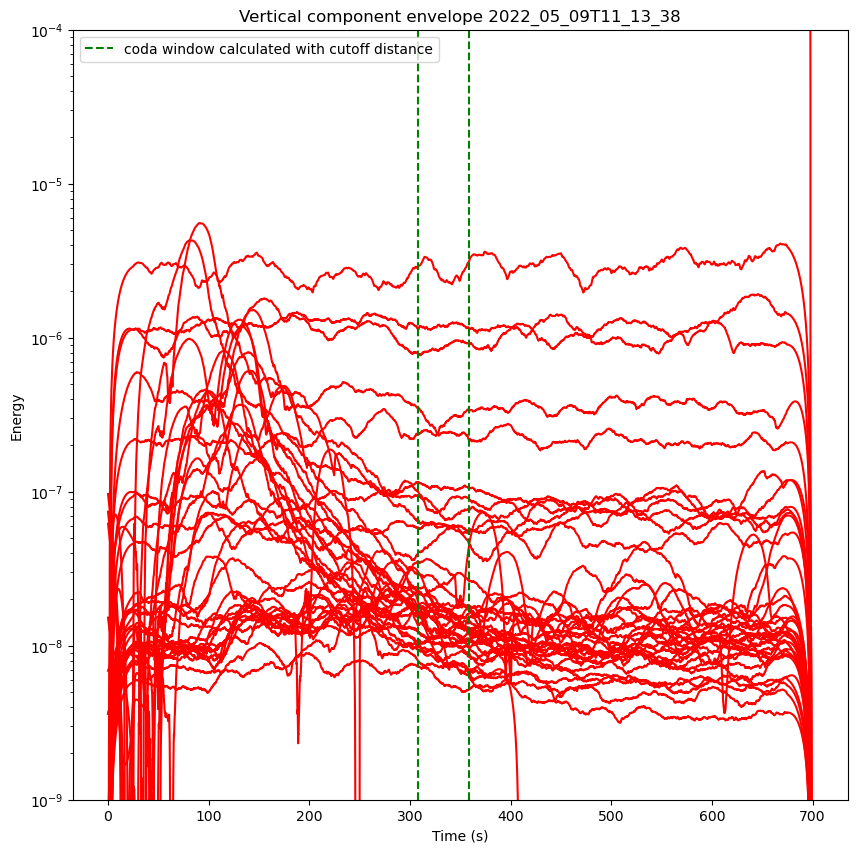

In [16]:
tset = smooth_plot_envelope(time_string, 50,st_envelope, tmincoda_dist=tcoda_test, tmaxcoda_dist=tcoda_test+50)

In [17]:
with open(f"C:/UGA/Stage/Data/{time_string}/{time_string}_{snr_threshold}_thresh_stations_with_amps.txt", "r") as file:
    amplitude_stations = json.load(file)

amplitude_stations = np.array(amplitude_stations)
coda_amp = select_ratio_dict('Coda', amplitude_stations)
common_stations = set(coda_amp.keys()) & set(envelopes_amps.keys())
#SNR_filtered_smoothed_envelope_st = 
coda_envelope_amp_dict = {
    station: (coda_amp[station], envelopes_amps[station]["amplitude"])
    for station in common_stations
}

print(coda_envelope_amp_dict)

file_path = "envelope350_470_coda.csv"
event_name = time_string

update_event_file(file_path, event_name, coda_envelope_amp_dict)


{'ORDF': (1.7197417425135865e-10, 9.446928936829199e-11), 'FUSIO': (2.3014533842926387e-10, 1.6783429514252933e-10), 'OLIV': (2.68843984855179e-10, 1.4183129985415872e-10), 'MTLF': (1.5421240103441225e-10, 9.673026815862413e-11), 'OGDF': (1.8743825223555516e-10, 1.1332020927982485e-10), 'ACB': (3.150696044091149e-09, 2.5132180161665733e-09), 'LRVF': (3.614523949699481e-09, 2.848122804275069e-09), 'SAOF': (2.9528594189756755e-10, 2.534335229799228e-10), 'NALPS': (1.841168733049396e-10, 1.1464826486289837e-10), 'MDI': (4.906487343880499e-10, 3.8892036244713406e-10), 'BDI': (2.367668410416796e-10, 1.8375863418425928e-10), 'CHIF': (3.5139000848553064e-10, 2.3175100406790784e-10), 'PERON': (2.364422063180344e-10, 1.5803706526564588e-10), 'ARBS': (1.2655944254867534e-10, 6.41866625618928e-11), 'NEUF': (1.454394972982144e-09, 1.025280279756613e-09), 'CPAL': (1.4816997551471862e-10, 1.11337621677939e-10), 'COLLE': (6.891483214757166e-10, 5.964835874057374e-10), 'BLAF': (1.7233681170964763e-10,

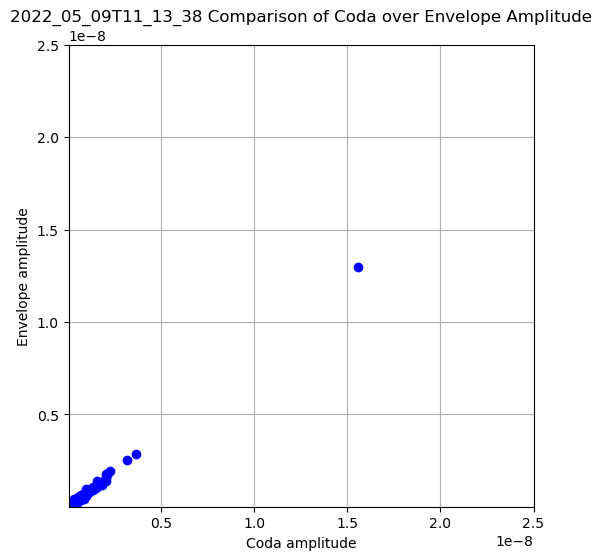

In [18]:
coda = [coda_amp[station] for station in common_stations]
envelope = [envelopes_amps[station]["amplitude"] for station in common_stations]



plt.figure(figsize=(6, 6))
plt.scatter(coda, envelope, color='b', label='Common Stations coda over envelope amplitude')

plt.xlabel('Coda amplitude')
plt.ylabel('Envelope amplitude')
plt.title(f'{time_string} Comparison of Coda over Envelope Amplitude')

#for station, x, y in zip(common_stations, coda, envelope):
#    plt.annotate(station, (x, y), textcoords="offset points", xytext=(5, 5), ha='right')

#plt.legend()
plt.xlim([1e-14,25e-9])
plt.ylim([1e-14,25e-9])
plt.grid(True)
plt.show()

304
304
slope is  1.3564607270829003


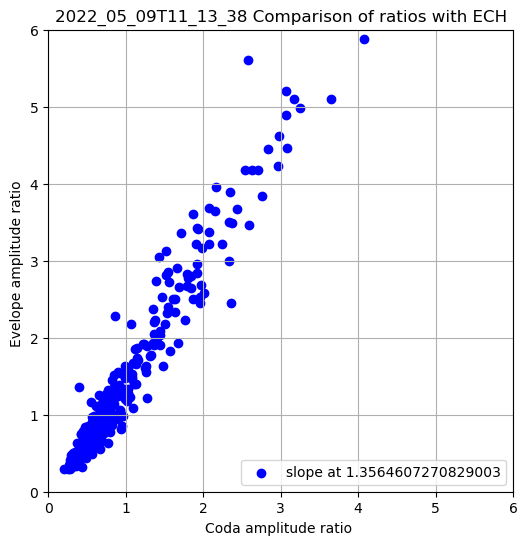

In [19]:
reference_station = 'ECH'

if reference_station in coda_amp and reference_station in envelopes_amps:
    ref_coda = coda_amp[reference_station]
    ref_envelope = envelopes_amps[reference_station]["amplitude"]
    common_stations = set(coda_amp.keys()) & set(envelopes_amps.keys()) - {reference_station}

    coda_ratio = [coda_amp[station] / ref_coda for station in common_stations]
    envelope_ratio = [envelopes_amps[station]["amplitude"] / ref_envelope for station in common_stations]
    print(len(coda_ratio))
    print(len(envelope_ratio))
    coef1 = np.polyfit(coda_ratio,envelope_ratio,1)
    print("slope is ", coef1[0])
    plt.figure(figsize=(6, 6))
    plt.scatter(coda_ratio, envelope_ratio, color='b', label=f'slope at {coef1[0]}')

    plt.xlabel(f'Coda amplitude ratio ')
    plt.ylabel(f'Evelope amplitude ratio ')
    plt.title(f'{time_string} Comparison of ratios with {reference_station}')

    #for station, x, y in zip(common_stations, coda_ratio, envelope_ratio):
    #    plt.annotate(station, (x, y), textcoords="offset points", xytext=(5, 5), ha='right')

    plt.legend()
    plt.xlim([0,6])
    plt.ylim([0,6])

    plt.grid(True)
    plt.show()

else:
    print(f"Reference station {reference_station} not found in both dictionaries.")


In [20]:


def update_event_file(file_path, event_name, station_data):
    """
    Update a CSV file with station-event data.
    
    :param file_path: Path to the CSV file.
    :param event_name: Name of the event (prefix for column names).
    :param station_data: Dictionary with station names as keys and tuples of values for the event.
    """
    # Load existing data if the file exists
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
    else:
        df = pd.DataFrame()

    col1 = f"{event_name}_coda"
    col2 = f"{event_name}_envelope"
    
    for col in [col1, col2]:
        if col not in df.columns:
            df[col] = 0.0 
    for station in station_data.keys():
        if station not in df.index:
            df.loc[station] = [0.0] * len(df.columns)

    df = df.astype({col1: float, col2: float})

    for station, (value1, value2) in station_data.items():
        df.at[station, col1] = float(value1)
        df.at[station, col2] = float(value2)

    df.to_csv(file_path)
    print(f"Updated {file_path} with event '{event_name}'.")



#coda_envelope_amp_dict = {station: (coda_amp[station], envelopes_amps[station]) for station in common_stations}

file_path = "envelope350_470_coda440_460.csv"
event_name = time_string

update_event_file(file_path, event_name, coda_envelope_amp_dict)





Updated envelope350_470_coda440_460.csv with event '2022_05_09T11_13_38'.


#### Testing with SNR filtered stations
If we have run envelope_routine, we have the amplitude of the coda in a specific window (two windows can be set), as well as the smoothed stream. We can run before the SNR routine, finding the tmin of the coda using the cutoff distance. We could compare with a global window we never change. 

In [21]:
snr_threshold = 2
eq_start = start
stationref = "ECH"



filtered_stations_with_SNR, stations_with_SNR, distance_dict, tcoda_test, filtered_st, stations_with_amps, amp_plot = SNR_all(stations_all, st_plot_filt_all, Dtmin_Pn, Dtmax_Pn, Dtmin_Sn, Dtmax_Sn, vLg_min,vLg_max,vPg_min, vPg_max, tminCoda, tmaxCoda,
         Dtmin_Noise, Dtmax_Noise,eq_start,eq_lat,eq_lon,snr_threshold=snr_threshold,plot_SNR=False,plot_amps=True, wavecode="Lg_Coda",dB=True)

#print(filtered_stations_with_SNR)
for i,tr in enumerate(st_envelope):
    if tr.stats.station == stationref:
        idx_reference = i

envelopes_amps, st_smooth = envelopes_routine1(time_string, st_envelope, ref_idx=idx_reference, plotting=False)

filtered_station_names = set(row[1] for row in filtered_stations_with_SNR) 
filtered_smooth_stream = obspy.Stream()
filtered_stream = obspy.Stream()
for trace in st_smooth:
    if trace.stats.station in filtered_station_names:
        filtered_smooth_stream.append(trace)
for trace in st_envelope:
    if trace.stats.station in filtered_station_names:
        filtered_stream.append(trace)




#for i,tr in enumerate(st_envelope_smooth_filtered):
#    if tr.stats.station == stationref:
#        idx_reference = i


calculating SNR for Pn  phase


c:\UGA\Stage\Scripts\new_functions.py:662: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPn,np.transpose(dataselectPn)))/len(dataselectPn)
c:\UGA\Stage\Scripts\new_functions.py:663: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)
c:\UGA\Stage\Scripts\new_functions.py:694: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPg,np.transpose(dataselectPg)))/len(dataselectPg)
c:\UGA\Stage\Scripts\new_functions.py:695: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Pg  phase
calculating SNR for Sn  phase


c:\UGA\Stage\Scripts\new_functions.py:678: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectSn,np.transpose(dataselectSn)))/len(dataselectSn)
c:\UGA\Stage\Scripts\new_functions.py:679: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Lg  phase


c:\UGA\Stage\Scripts\new_functions.py:646: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectLg,np.transpose(dataselectLg)))/len(dataselectLg)
c:\UGA\Stage\Scripts\new_functions.py:647: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


Reduced from   634  stations to   338  stations due to insufficient SNR or distance >  820.0608173717575
coda window set from 308.43609549468385-358.43609549468385s
plotting Lg_Coda amplitudes


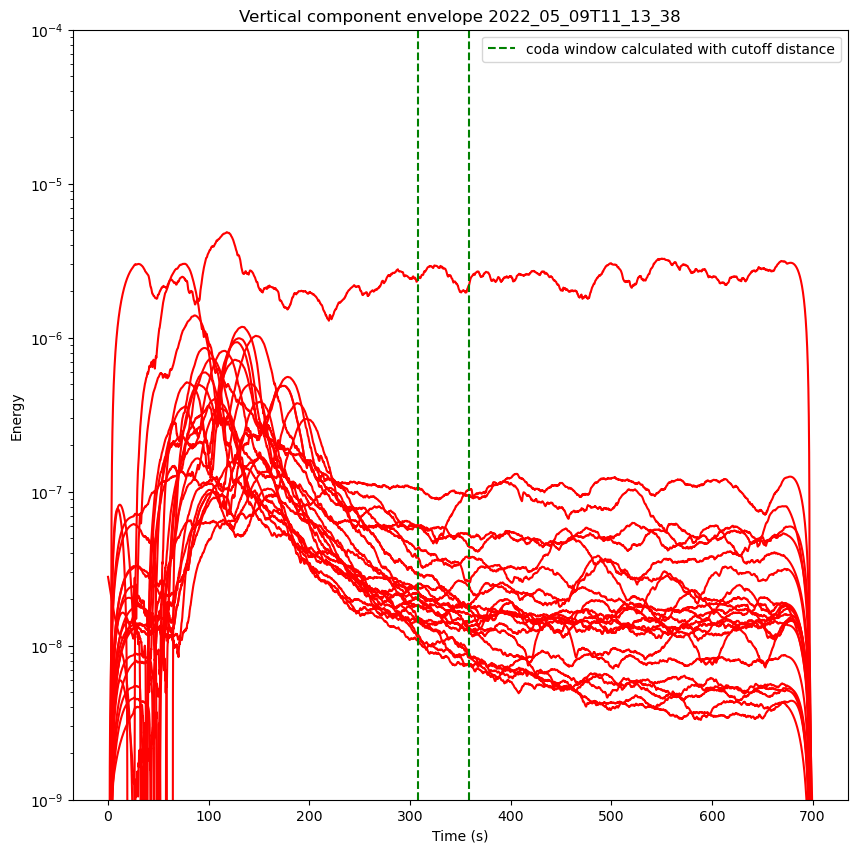

In [27]:
plot_filtered_smoothed = smooth_plot_envelope(time_string, 50,filtered_stream,tmincoda_dist=tcoda_test, tmaxcoda_dist=tcoda_test+50)

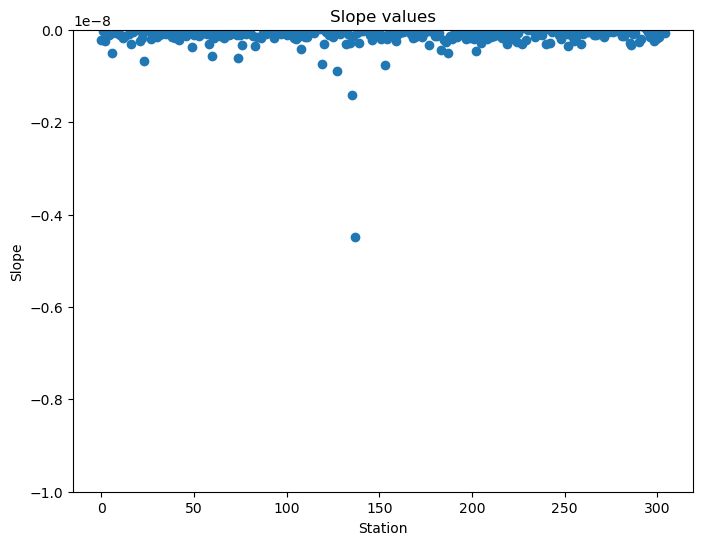

In [23]:
#envelopes_amps[station]["amplitude"]
#print(envelopes_amps)



common_stations = set(row[1] for row in filtered_stations_with_SNR) & set(envelopes_amps.keys())
slope_filt = [envelopes_amps[station]["coda_dist_slope"] for station in common_stations]
slope_filt_ampl = np.array(slope_filt) * 1e9
#vals_abs = np.abs(slope_filt)
plt.figure(figsize=(8, 6))
#bins = np.logspace(np.log10(vals_abs.min()), np.log10(vals_abs.max()), 15)
#plt.hist(slope_filt_ampl, bins=bins, edgecolor='black', alpha=0.7)

plt.scatter(np.arange(len(slope_filt)),slope_filt)

plt.ylabel("Slope")
plt.xlabel("Station")
plt.title("Slope values")
#plt.xscale("log")
plt.ylim([-1e-8,0])

plt.show()


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  1.,  2.,  2.,  3.,  6., 20., 39., 78., 86.]),
 array([-4.00e-09, -3.92e-09, -3.84e-09, -3.76e-09, -3.68e-09, -3.60e-09,
        -3.52e-09, -3.44e-09, -3.36e-09, -3.28e-09, -3.20e-09, -3.12e-09,
        -3.04e-09, -2.96e-09, -2.88e-09, -2.80e-09, -2.72e-09, -2.64e-09,
        -2.56e-09, -2.48e-09, -2.40e-09, -2.32e-09, -2.24e-09, -2.16e-09,
        -2.08e-09, -2.00e-09, -1.92e-09, -1.84e-09, -1.76e-09, -1.68e-09,
        -1.60e-09, -1.52e-09, -1.44e-09, -1.36e-09, -1.28e-09, -1.20e-09,
        -1.12e-09, -1.04e-09, -9.60e-10, -8.80e-10, -8.00e-10, -7.20e-10,
        -6.40e-10, -5.60e-10, -4.80e-10, -4.00e-10, -3.20e-10, -2.40e-10,
        -1.60e-10, -8.00e-11,  0.00e+00]),
 <BarContainer object of 50 artists>)

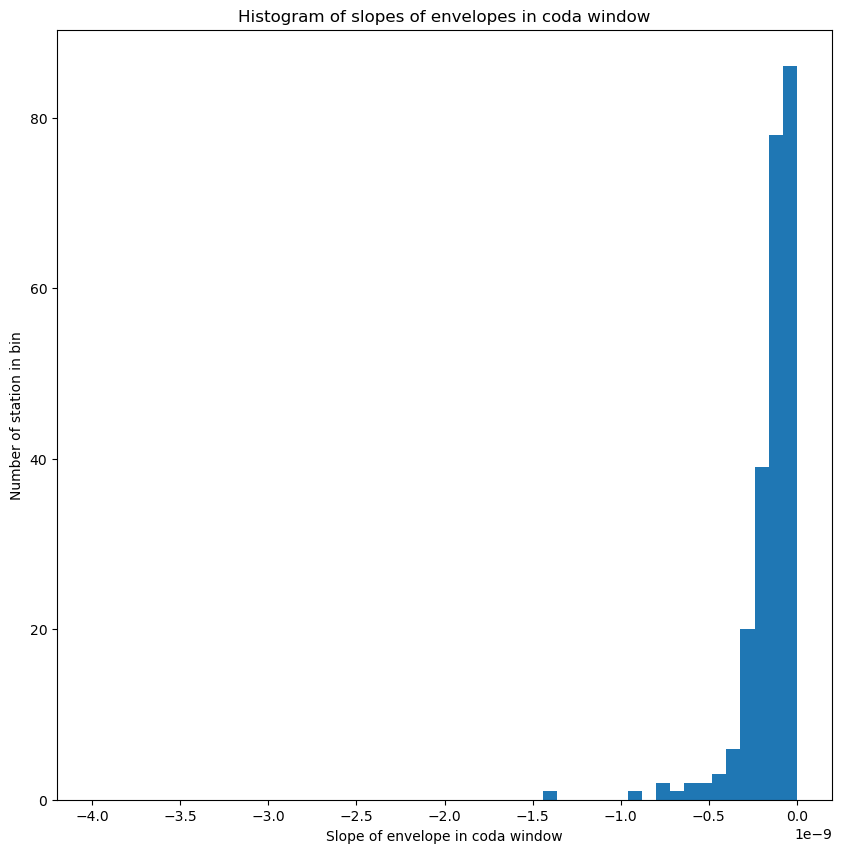

In [24]:
plt.figure(figsize=(10,10))
plt.xlabel('Slope of envelope in coda window')
plt.ylabel('Number of station in bin')
plt.title('Histogram of slopes of envelopes in coda window')
plt.hist(slope_filt,bins=50,range=(-4e-9,0))

In [25]:
def check_availability(eq_list, station_name):
    download_counter = 0
    no_data_counter = 0
    not_listed_counter = 0

    for event in eq_list:
        time_string = UTCDateTime.strftime(event, format="%Y_%m_%dT%H_%M_%S")

        with open(f"C:/UGA/Stage/Data/{time_string}/{time_string}.txt", "r") as file:
            availability = json.load(file)

        with open(f"{mag_dir}{time_string}.txt", "r") as meta:
            for line in meta:
                if line.startswith("Magnitude:"):
                    magnitude = float(line.split(":")[1].strip())
                    mags.append(magnitude)
        

In [26]:
import os
import csv

event_list_file = "europe_bigger_than_5.csv"
output_file = "event_summary.csv"

event_files_dir = "./event_files"

with open(event_list_file, "r") as f:
    events = [line.strip() for line in f.readlines()]

with open(output_file, "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Event", "Available", "Not Available", "Not Listed"])

    for event in events:
        event_file = os.path.join(event_files_dir, f"{event}.txt")

        available = 0
        not_available = 0
        not_listed = 0

        if os.path.exists(event_file):
            with open(event_file, "r") as ef:
                for line in ef:
                    parts = line.strip().split(",")
                    if len(parts) != 2:
                        continue 

                    station, status = parts

                    if status.lower() == "downloaded":
                        available += 1
                    elif status in ["204", "404"]:
                        not_available += 1
                    else:
                        not_listed += 1
        else:
            not_listed += 1
        csv_writer.writerow([event, available, not_available, not_listed])

print(f"Summary written to {output_file}")


Summary written to event_summary.csv
